In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pickle
import itertools

import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import probplot
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import  learning_curve
from sklearn.model_selection import ShuffleSplit

C:\Users\Sladkish\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\Sladkish\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
#функция которая выводит график признаков отранжированный по их важности в модели
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [3]:
#вывод метрик качетва для нашей модели, F1, precision, recall
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    
    print('CONFUSION MATRIX TEST\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
#Подбор оптимального размера выборки, кривая обучения
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [5]:
#Выбор порога вероятности для определения класса
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [6]:
# Балансировка целевой переменной
def balance_df_by_target(df, target_name='Credit Default'):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) # случайгое перемешивание данных

### Загружаю тренировочные данные и начинаю их подготавливать

In [7]:
df_train=pd.read_csv('course_project_train.csv')

In [8]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [10]:
df_train.shape

(7500, 17)

### Смотрю целевую переменную.

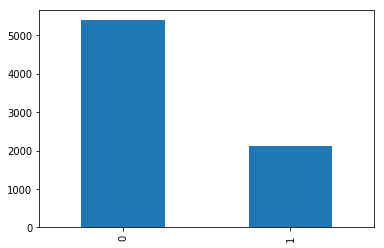

In [11]:
df_train['Credit Default'].value_counts().plot(kind='bar')

In [12]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

##### Как видим данные не сбалансированны. В дальнешем придется их балансировать перед обучением модели

Далее смотрю пропуски в данных

In [13]:
df_train.count()

Home Ownership                  7500
Annual Income                   5943
Years in current job            7129
Tax Liens                       7500
Number of Open Accounts         7500
Years of Credit History         7500
Maximum Open Credit             7500
Number of Credit Problems       7500
Months since last delinquent    3419
Bankruptcies                    7486
Purpose                         7500
Term                            7500
Current Loan Amount             7500
Current Credit Balance          7500
Monthly Debt                    7500
Credit Score                    5943
Credit Default                  7500
dtype: int64

In [14]:
len(df_train)-df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

#### Из категориального признака TERM делаю числовой признак

In [15]:
df_train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [16]:
df_train['Term']=df_train['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [17]:
df_train['Term'].value_counts()

1    5556
0    1944
Name: Term, dtype: int64

Заполняю пропуски

In [18]:
df_train['Months since last delinquent'].mode()

0    14.0
dtype: float64

In [19]:
df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] =df_train['Months since last delinquent'].mode()[0]

In [20]:
df_train['Annual Income'].median()

1168386.0

In [21]:
df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] =df_train['Annual Income'].median()

In [22]:
df_train['Credit Score'].mode()

0    740.0
dtype: float64

In [23]:
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score' ]  =df_train['Credit Score'].mode()[0]

In [24]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [25]:
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies']=0

Заполнять пропуски в признаке  'Years in current job' не стал, так как по моим наблюдениям это плохо отражалось на качетве финальной модели

In [26]:
# df_train['Years in current job'].mode()

In [27]:
# df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] =df_train['Years in current job'].mode()[0]

In [28]:
len(df_train)-df_train.count()

Home Ownership                    0
Annual Income                     0
Years in current job            371
Tax Liens                         0
Number of Open Accounts           0
Years of Credit History           0
Maximum Open Credit               0
Number of Credit Problems         0
Months since last delinquent      0
Bankruptcies                      0
Purpose                           0
Term                              0
Current Loan Amount               0
Current Credit Balance            0
Monthly Debt                      0
Credit Score                      0
Credit Default                    0
dtype: int64

Строю матрицу корреляции

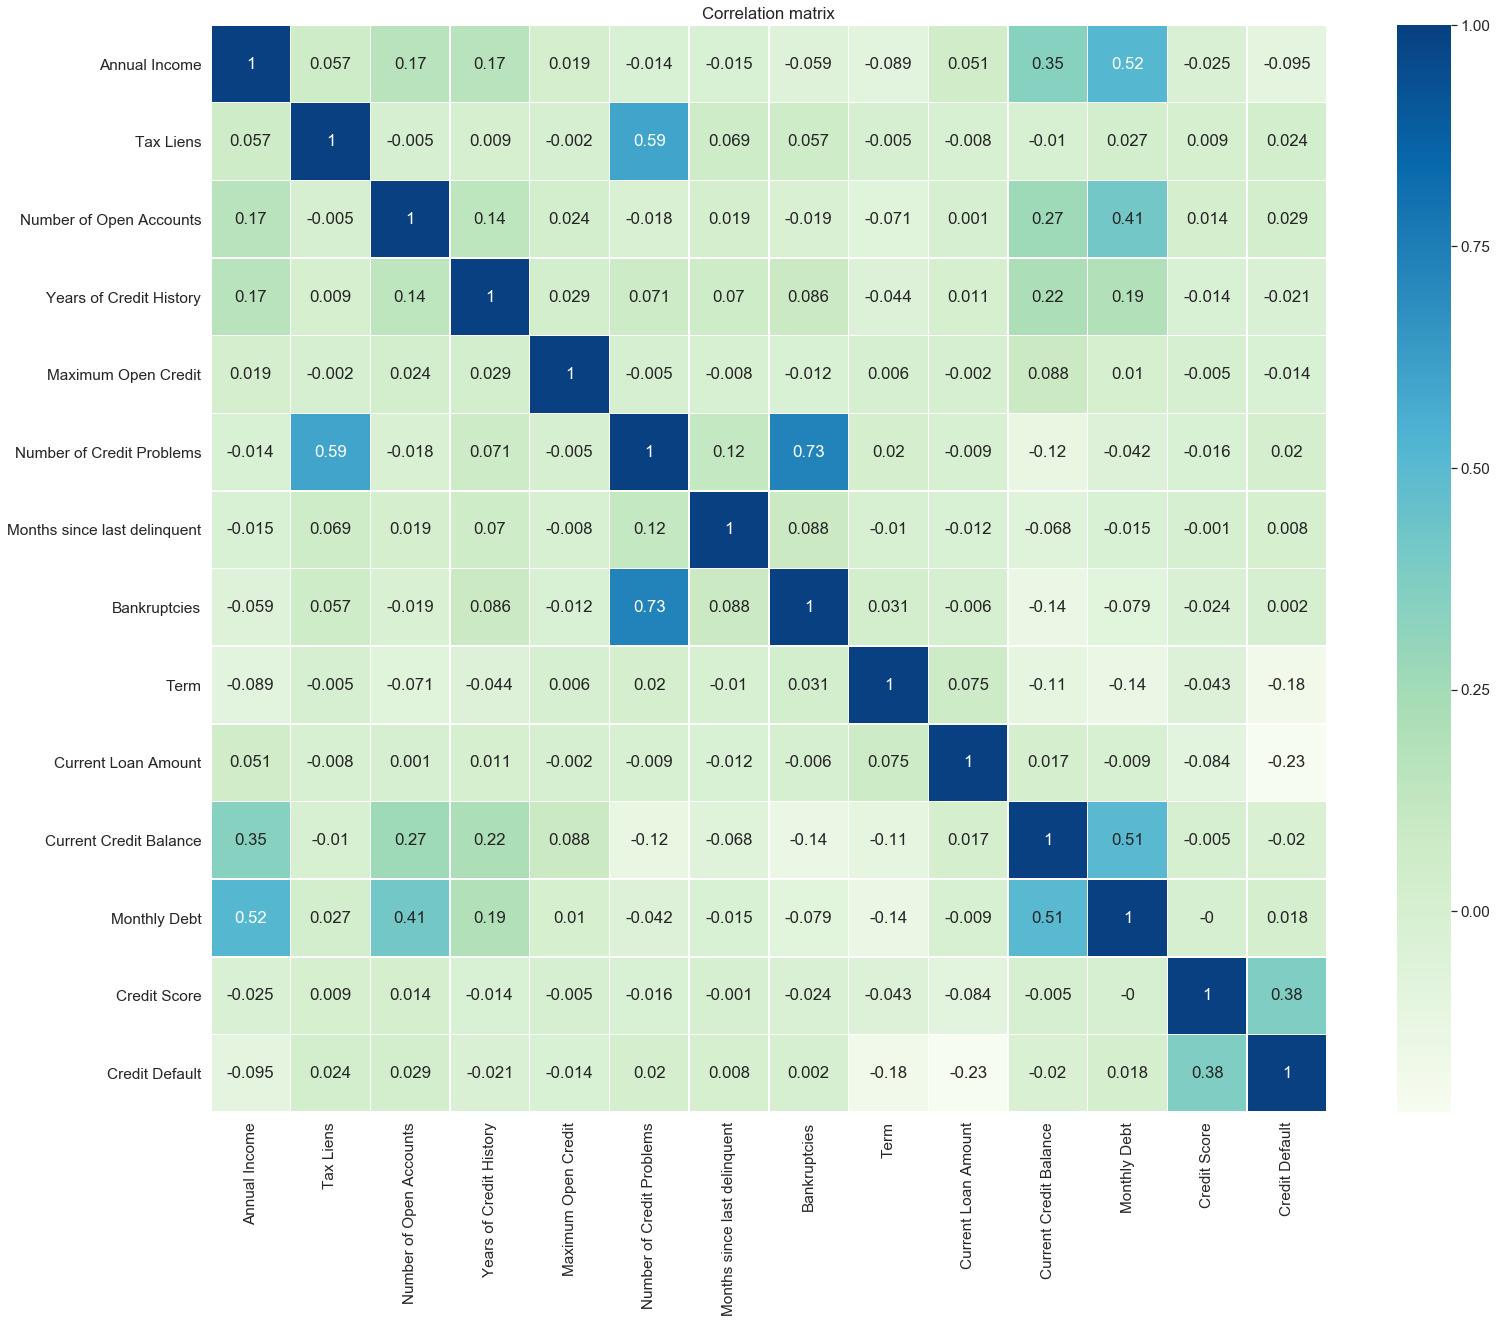

In [29]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_train.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

#### Выделим числовые и категориальные признаки:

In [30]:
object_columns=df_train.select_dtypes(include='object').columns[:]
object_columns

Index(['Home Ownership', 'Years in current job', 'Purpose'], dtype='object')

In [31]:
df_train[object_columns].head()

,Home Ownership,Years in current job,Purpose
0,Own Home,NaN,debt consolidation
1,Own Home,10+ years,debt consolidation
2,Home Mortgage,8 years,debt consolidation
3,Own Home,6 years,debt consolidation
4,Rent,8 years,debt consolidation


In [32]:
numerical_columns   = [c for c in df_train.columns if df_train[c].dtype.name != 'object']

In [33]:
df_train[numerical_columns].head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,482087.0,0.0,11.0,26.3,685960.0,1.0,14.0,1.0,1,99999999.0,47386.0,7914.0,749.0,0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,14.0,0.0,0,264968.0,394972.0,18373.0,737.0,1
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,14.0,0.0,1,99999999.0,308389.0,13651.0,742.0,0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,14.0,1.0,1,121396.0,95855.0,11338.0,694.0,0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,14.0,0.0,1,125840.0,93309.0,7180.0,719.0,0


In [34]:
df_train_categorical=df_train[object_columns]

In [35]:
df_train_categorical.head()

,Home Ownership,Years in current job,Purpose
0,Own Home,NaN,debt consolidation
1,Own Home,10+ years,debt consolidation
2,Home Mortgage,8 years,debt consolidation
3,Own Home,6 years,debt consolidation
4,Rent,8 years,debt consolidation


In [36]:
df_train_numeric=df_train[numerical_columns]

In [37]:
df_train_numeric.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,482087.0,0.0,11.0,26.3,685960.0,1.0,14.0,1.0,1,99999999.0,47386.0,7914.0,749.0,0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,14.0,0.0,0,264968.0,394972.0,18373.0,737.0,1
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,14.0,0.0,1,99999999.0,308389.0,13651.0,742.0,0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,14.0,1.0,1,121396.0,95855.0,11338.0,694.0,0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,14.0,0.0,1,125840.0,93309.0,7180.0,719.0,0


#### Далее ввожу дамми переменные для категориальных признаков 

In [38]:
df_train_dummy=pd.get_dummies(df_train_categorical)

In [39]:
df_train_dummy.head()

,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### И бъединяю все в один датасет

In [40]:
df_train_with_dummy=pd.concat([df_train_numeric, df_train_dummy], axis=1)

In [41]:
df_train_with_dummy.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,482087.0,0.0,11.0,26.3,685960.0,1.0,14.0,1.0,1,99999999.0,...,0,0,0,0,0,0,0,0,0,0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,14.0,0.0,0,264968.0,...,0,0,0,0,0,0,0,0,0,0
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,14.0,0.0,1,99999999.0,...,0,0,0,0,0,0,0,0,0,0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,14.0,1.0,1,121396.0,...,0,0,0,0,0,0,0,0,0,0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,14.0,0.0,1,125840.0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# удаляю следующий признак потому, что его нет в тестовом датасете
df_train_with_dummy = df_train_with_dummy.drop(columns='Purpose_renewable energy')

#### Переименовываю один признак так как далее lightGBM из за этого выдавал ошибку

In [43]:
df_train_with_dummy.rename(columns={'Years in current job_< 1 year': 'Years in current job less 1 year'}, inplace=True)

#### Строим модель lightGBM

In [44]:
df_train[object_columns] = df_train[object_columns].astype('category')

In [45]:
TARGET_NAME='Credit Default'

In [46]:
FEATURE_NAMES_SELECTED=['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
                        'Number of Credit Problems', 'Months since last delinquent', 
                        'Bankruptcies', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score',
                       'Home Ownership', 'Years in current job', 'Purpose']

In [47]:
X = df_train[FEATURE_NAMES_SELECTED]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)

#### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [48]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

C:\Users\Sladkish\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  
C:\Users\Sladkish\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  import sys


0    4074
1    3102
Name: Credit Default, dtype: int64

In [49]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

#### Cтроим модель без категориальных признаков

In [50]:
model_lgbm1 = lgbm.LGBMClassifier(max_depth=3)

model_lgbm1.fit(X_train, y_train)

y_train_pred1 = model_lgbm1.predict(X_train)
y_test_pred1 = model_lgbm1.predict(X_test)

get_classification_report(y_train, y_train_pred1, y_test, y_test_pred1)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.87      0.79      4074
           1       0.77      0.57      0.66      3102

   micro avg       0.74      0.74      0.74      7176
   macro avg       0.75      0.72      0.72      7176
weighted avg       0.75      0.74      0.73      7176

TEST

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1313
           1       0.56      0.49      0.52       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.68      0.66      0.67      1875
weighted avg       0.72      0.73      0.73      1875

CONFUSION MATRIX TEST

col_0              0    1
Credit Default           
0               1100  213
1                289  273


In [51]:
model_lgbm2 = lgbm.LGBMClassifier(max_depth=3,
                       catgorical_feature=['Home Ownership','Years in current job' , 'Purpose']   
                      )

model_lgbm2.fit(X_train, y_train)

y_train_pred2 = model_lgbm2.predict(X_train)
y_test_pred2 = model_lgbm2.predict(X_test)

get_classification_report(y_train, y_train_pred2, y_test, y_test_pred2)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.87      0.79      4074
           1       0.77      0.57      0.66      3102

   micro avg       0.74      0.74      0.74      7176
   macro avg       0.75      0.72      0.72      7176
weighted avg       0.75      0.74      0.73      7176

TEST

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1313
           1       0.56      0.49      0.52       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.68      0.66      0.67      1875
weighted avg       0.72      0.73      0.73      1875

CONFUSION MATRIX TEST

col_0              0    1
Credit Default           
0               1100  213
1                289  273


#### Как видим добавление перечня категориальных признаков не изменило качество модели lightGBM

### Далее строим модели на датасете, где категориальные признаки заменены дамми переменными

In [52]:
data= df_train_with_dummy.drop((TARGET_NAME), axis=1)

In [53]:
data = pd.DataFrame(data, dtype=float)

In [54]:
X = data
y = df_train[TARGET_NAME]
feature_names = X.columns
print(feature_names)

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Term', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Years in current job_1 year',
       'Years in current job_10+ years', 'Years in current job_2 years',
       'Years in current job_3 years', 'Years in current job_4 years',
       'Years in current job_5 years', 'Years in current job_6 years',
       'Years in current job_7 years', 'Years in current job_8 years',
       'Years in current job_9 years', 'Years in current job less 1 year',
       'Purpose_business loan', 'Purpose_buy a car', 'Purpose_buy house',
       'Purpose_debt consolidation', 'Purpose_educational expenses',
       'Purpose_home improvem

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)

In [56]:
X.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,...,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,482087.0,0.0,11.0,26.3,685960.0,1.0,14.0,1.0,1.0,99999999.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,14.0,0.0,0.0,264968.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,14.0,0.0,1.0,99999999.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,14.0,1.0,1.0,121396.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,14.0,0.0,1.0,125840.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

C:\Users\Sladkish\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  
C:\Users\Sladkish\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  import sys


0    4074
1    3102
Name: Credit Default, dtype: int64

In [58]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [59]:
model_lgbm3 = lgbm.LGBMClassifier(max_depth=3)

In [60]:
model_lgbm3.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=3,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [61]:
y_train_pred3 = model_lgbm3.predict(X_train)
y_test_pred3= model_lgbm3.predict(X_test)

get_classification_report(y_train, y_train_pred3, y_test, y_test_pred3)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.87      0.79      4074
           1       0.77      0.57      0.66      3102

   micro avg       0.74      0.74      0.74      7176
   macro avg       0.75      0.72      0.73      7176
weighted avg       0.75      0.74      0.73      7176

TEST

              precision    recall  f1-score   support

           0       0.79      0.84      0.82      1313
           1       0.57      0.49      0.52       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.68      0.66      0.67      1875
weighted avg       0.73      0.73      0.73      1875

CONFUSION MATRIX TEST

col_0              0    1
Credit Default           
0               1104  209
1                288  274


#### Как видим качетво lightGBM модели на датасете с дамми переменными не сильно изменилось

#### Строим модель XGBoost

In [62]:
model_xgb4 = XGBClassifier(max_depth=3,
                       max_leaves=15,
                       reg_lambda=15)

In [63]:
model_xgb4.fit(X_train, y_train)
y_pred=model_xgb4.predict(X_test)
y_train_pred4 = model_xgb4.predict(X_train)
y_test_pred4 = model_xgb4.predict(X_test)

In [64]:
get_classification_report(y_train, y_train_pred4, y_test, y_test_pred4)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      4074
           1       0.80      0.67      0.73      3102

   micro avg       0.78      0.78      0.78      7176
   macro avg       0.79      0.77      0.77      7176
weighted avg       0.79      0.78      0.78      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1313
           1       0.55      0.52      0.54       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.67      0.67      0.67      1875
weighted avg       0.72      0.73      0.73      1875

CONFUSION MATRIX TEST

col_0              0    1
Credit Default           
0               1072  241
1                268  294


#### Качество модели XGBoost мне нарвиться больше.

#### Далее пробую подобрать пареметры и релизовать обучение с помощью кросс-валидации. На сколько я все сдела правильно не знаю)

In [65]:
model_xgb5 = XGBClassifier(reg_lambda=10, colsample_bytree=0.8, learning_rate= 0.1, max_depth=1, n_estimators=600, subsample= 0.8, max_leaves=12,
                                      silent=True, random_state=42)

In [66]:
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
for train, test in ss.split(df_train_with_dummy):

    df_balanced = balance_df_by_target(df_train_with_dummy.iloc[train], TARGET_NAME)
    
    X_train = df_balanced.drop(columns=TARGET_NAME)
    y_train = df_balanced[TARGET_NAME]
    

    X_test= df_train_with_dummy.iloc[test].drop((TARGET_NAME), axis=1)   
    y_test = df_train_with_dummy.iloc[test][TARGET_NAME]
    
    model_xgb5.fit(X_train, y_train)
    y_pred= model_xgb5.predict(X_test)
    y_train_pred5 = model_xgb5.predict(X_train)
    y_test_pred5 = model_xgb5.predict(X_test)
    y_test_pred_probs5 = model_xgb5.predict_proba(X_test)
    get_classification_report(y_train, y_train_pred5, y_test, y_test_pred5)


C:\Users\Sladkish\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  
C:\Users\Sladkish\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  import sys


TRAIN

              precision    recall  f1-score   support

           0       0.72      0.84      0.78      4074
           1       0.73      0.57      0.64      3102

   micro avg       0.72      0.72      0.72      7176
   macro avg       0.73      0.71      0.71      7176
weighted avg       0.72      0.72      0.72      7176

TEST

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1313
           1       0.56      0.54      0.55       562

   micro avg       0.74      0.74      0.74      1875
   macro avg       0.68      0.68      0.68      1875
weighted avg       0.73      0.74      0.73      1875

CONFUSION MATRIX TEST

col_0              0    1
Credit Default           
0               1079  234
1                260  302
TRAIN

              precision    recall  f1-score   support

           0       0.71      0.84      0.77      4052
           1       0.73      0.56      0.64      3146

   micro avg       0.72      0.72  

#### Проверяю выбор порога вероятности 

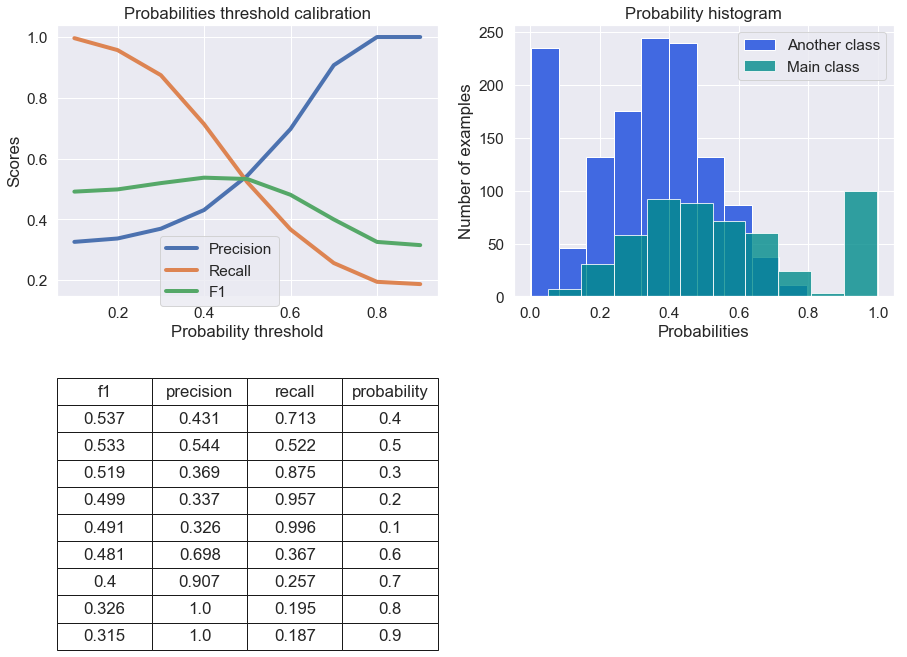

In [67]:
show_proba_calibration_plots(y_test_pred_probs5[:, 1], y_test)

#### Для моей модели порог p=0.50 который стоит по умолчанию, является оптимальным

### Важность признаков

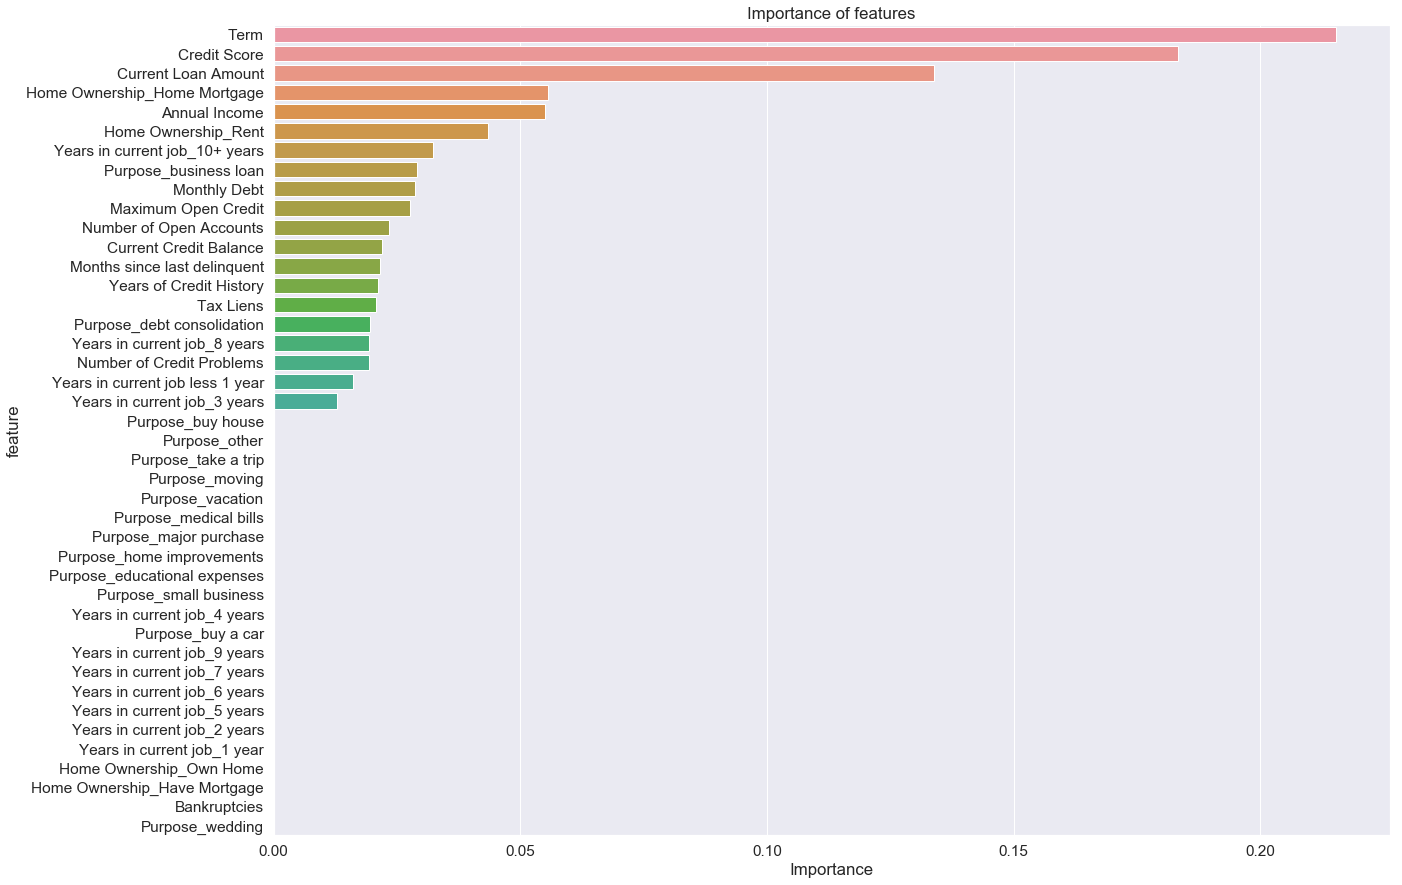

In [68]:
important_features_top = show_feature_importances(X_train.columns, model_xgb5.feature_importances_, get_top=20)

In [69]:
important_features_top

['Term',
 'Credit Score',
 'Current Loan Amount',
 'Home Ownership_Home Mortgage',
 'Annual Income',
 'Home Ownership_Rent',
 'Years in current job_10+ years',
 'Purpose_business loan',
 'Monthly Debt',
 'Maximum Open Credit',
 'Number of Open Accounts',
 'Current Credit Balance',
 'Months since last delinquent',
 'Years of Credit History',
 'Tax Liens',
 'Purpose_debt consolidation',
 'Years in current job_8 years',
 'Number of Credit Problems',
 'Years in current job less 1 year',
 'Years in current job_3 years']

In [70]:
important_features_top.append(TARGET_NAME)
important_features_top

['Term',
 'Credit Score',
 'Current Loan Amount',
 'Home Ownership_Home Mortgage',
 'Annual Income',
 'Home Ownership_Rent',
 'Years in current job_10+ years',
 'Purpose_business loan',
 'Monthly Debt',
 'Maximum Open Credit',
 'Number of Open Accounts',
 'Current Credit Balance',
 'Months since last delinquent',
 'Years of Credit History',
 'Tax Liens',
 'Purpose_debt consolidation',
 'Years in current job_8 years',
 'Number of Credit Problems',
 'Years in current job less 1 year',
 'Years in current job_3 years',
 'Credit Default']

In [71]:
short_data=df_train_with_dummy[important_features_top]

In [72]:
short_data.head()

,Term,Credit Score,Current Loan Amount,Home Ownership_Home Mortgage,Annual Income,Home Ownership_Rent,Years in current job_10+ years,Purpose_business loan,Monthly Debt,Maximum Open Credit,...,Current Credit Balance,Months since last delinquent,Years of Credit History,Tax Liens,Purpose_debt consolidation,Years in current job_8 years,Number of Credit Problems,Years in current job less 1 year,Years in current job_3 years,Credit Default
0,1,749.0,99999999.0,0,482087.0,0,0,0,7914.0,685960.0,...,47386.0,14.0,26.3,0.0,1,0,1.0,0,0,0
1,0,737.0,264968.0,0,1025487.0,0,1,0,18373.0,1181730.0,...,394972.0,14.0,15.3,0.0,1,0,0.0,0,0,1
2,1,742.0,99999999.0,1,751412.0,0,0,0,13651.0,1182434.0,...,308389.0,14.0,35.0,0.0,1,1,0.0,0,0,0
3,1,694.0,121396.0,0,805068.0,0,0,0,11338.0,147400.0,...,95855.0,14.0,22.5,0.0,1,0,1.0,0,0,0
4,1,719.0,125840.0,0,776264.0,1,0,0,7180.0,385836.0,...,93309.0,14.0,13.6,0.0,1,1,1.0,0,0,0


In [73]:
model_xgb6 = XGBClassifier(reg_lambda=10, colsample_bytree=0.8, learning_rate= 0.1, max_depth=1, n_estimators=600, subsample= 0.8, max_leaves=12,
                                      silent=True, random_state=42)

In [74]:
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
for train, test in ss.split(short_data):

    df_balanced = balance_df_by_target(short_data.iloc[train], TARGET_NAME)
    
    X_train = df_balanced.drop(columns=TARGET_NAME)
    y_train = df_balanced[TARGET_NAME]
    

    X_test= short_data.iloc[test].drop((TARGET_NAME), axis=1)   
    y_test = short_data.iloc[test][TARGET_NAME]
    
    model_xgb6.fit(X_train, y_train)
    y_pred= model_xgb6.predict(X_test)
    y_train_pred6 = model_xgb6.predict(X_train)
    y_test_pred6 = model_xgb6.predict(X_test)
    y_test_pred_probs6 = model_xgb6.predict_proba(X_test)
    get_classification_report(y_train, y_train_pred6, y_test, y_test_pred6)

C:\Users\Sladkish\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  
C:\Users\Sladkish\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  import sys


TRAIN

              precision    recall  f1-score   support

           0       0.72      0.84      0.77      4074
           1       0.73      0.57      0.64      3102

   micro avg       0.72      0.72      0.72      7176
   macro avg       0.72      0.70      0.71      7176
weighted avg       0.72      0.72      0.72      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1313
           1       0.56      0.53      0.55       562

   micro avg       0.74      0.74      0.74      1875
   macro avg       0.68      0.68      0.68      1875
weighted avg       0.73      0.74      0.73      1875

CONFUSION MATRIX TEST

col_0              0    1
Credit Default           
0               1081  232
1                264  298
TRAIN

              precision    recall  f1-score   support

           0       0.71      0.83      0.77      4052
           1       0.73      0.56      0.64      3146

   micro avg       0.72      0.72  

особой разницы я не увидел между обучением на всем датасете и на датасете из 20 важных признаков, по этому оставляю предыдущую модель

### Финальная модель

In [75]:
final_model = XGBClassifier(reg_lambda=10, colsample_bytree=0.8, learning_rate= 0.1, max_depth=1, n_estimators=600, subsample= 0.8, max_leaves=12,
                                      silent=True, random_state=42)
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
for train, test in ss.split(df_train_with_dummy):

    df_balanced = balance_df_by_target(df_train_with_dummy.iloc[train], TARGET_NAME)
    
    X_train = df_balanced.drop(columns=TARGET_NAME)
    y_train = df_balanced[TARGET_NAME]
    

    X_test= df_train_with_dummy.iloc[test].drop((TARGET_NAME), axis=1)   
    y_test = df_train_with_dummy.iloc[test][TARGET_NAME]
    
    final_model.fit(X_train, y_train)
    y_pred= final_model.predict(X_test)
    y_train_pred = final_model.predict(X_train)
    y_test_pred = final_model.predict(X_test)
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

C:\Users\Sladkish\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  
C:\Users\Sladkish\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  import sys


TRAIN

              precision    recall  f1-score   support

           0       0.72      0.84      0.77      4074
           1       0.73      0.57      0.64      3102

   micro avg       0.72      0.72      0.72      7176
   macro avg       0.72      0.70      0.71      7176
weighted avg       0.72      0.72      0.72      7176

TEST

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1313
           1       0.56      0.52      0.54       562

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.68      0.67      0.68      1875
weighted avg       0.73      0.73      0.73      1875

CONFUSION MATRIX TEST

col_0              0    1
Credit Default           
0               1080  233
1                268  294
TRAIN

              precision    recall  f1-score   support

           0       0.71      0.84      0.77      4052
           1       0.73      0.56      0.63      3146

   micro avg       0.72      0.72  

### Сохранение финальной модели

In [76]:
MODEL_FILE_PATH = 'models/model.pkl'

In [77]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

### Загружаю тестовые данные и начинаю их подготавливать аналогично тому как делал на тренировочных данных

In [78]:
df_test = pd.read_csv('course_project_test.csv')

In [79]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [80]:
df_test.shape

(2500, 16)

In [81]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(12), object(4)
me

In [82]:
df_test.count()

Home Ownership                  2500
Annual Income                   1987
Years in current job            2414
Tax Liens                       2500
Number of Open Accounts         2500
Years of Credit History         2500
Maximum Open Credit             2500
Number of Credit Problems       2500
Months since last delinquent    1142
Bankruptcies                    2497
Purpose                         2500
Term                            2500
Current Loan Amount             2500
Current Credit Balance          2500
Monthly Debt                    2500
Credit Score                    1987
dtype: int64

In [83]:
len(df_test)-df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [84]:
df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] =df_test['Annual Income'].median()

In [85]:
df_test['Credit Score'].mode()

0    746.0
dtype: float64

In [86]:
df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score' ]  =df_test['Credit Score'].mode()[0]

In [87]:
df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] =df_test['Months since last delinquent'].mode()[0]

In [88]:
df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies']=0

In [89]:
len(df_test)-df_test.count()

Home Ownership                   0
Annual Income                    0
Years in current job            86
Tax Liens                        0
Number of Open Accounts          0
Years of Credit History          0
Maximum Open Credit              0
Number of Credit Problems        0
Months since last delinquent     0
Bankruptcies                     0
Purpose                          0
Term                             0
Current Loan Amount              0
Current Credit Balance           0
Monthly Debt                     0
Credit Score                     0
dtype: int64

In [90]:
df_test['Term']=df_test['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [91]:
df_test['Purpose'].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
vacation                   3
educational expenses       3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

In [92]:
object_columns=df_test.select_dtypes(include='object').columns[:]
object_columns

Index(['Home Ownership', 'Years in current job', 'Purpose'], dtype='object')

In [93]:
df_test[object_columns].head()

,Home Ownership,Years in current job,Purpose
0,Rent,4 years,debt consolidation
1,Rent,1 year,educational expenses
2,Home Mortgage,3 years,debt consolidation
3,Home Mortgage,10+ years,debt consolidation
4,Home Mortgage,6 years,debt consolidation


In [94]:
numerical_columns   = [c for c in df_test.columns if df_test[c].dtype.name != 'object']

In [95]:
df_test[numerical_columns].head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,1178475.0,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,1,162470.0,105906.0,6813.0,746.0
1,231838.0,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,1,78298.0,46037.0,2318.0,699.0
2,1152540.0,0.0,10.0,13.7,204600.0,0.0,16.0,0.0,1,200178.0,146490.0,18729.0,7260.0
3,1220313.0,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,1,217382.0,213199.0,27559.0,739.0
4,2340952.0,0.0,11.0,23.6,1207272.0,0.0,16.0,0.0,0,777634.0,425391.0,42605.0,706.0


In [96]:
df_test_categorical=df_test[object_columns]

In [97]:
df_test_categorical.head()

,Home Ownership,Years in current job,Purpose
0,Rent,4 years,debt consolidation
1,Rent,1 year,educational expenses
2,Home Mortgage,3 years,debt consolidation
3,Home Mortgage,10+ years,debt consolidation
4,Home Mortgage,6 years,debt consolidation


In [98]:
df_test_numeric=df_test[numerical_columns]

In [99]:
df_test_numeric.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,1178475.0,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,1,162470.0,105906.0,6813.0,746.0
1,231838.0,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,1,78298.0,46037.0,2318.0,699.0
2,1152540.0,0.0,10.0,13.7,204600.0,0.0,16.0,0.0,1,200178.0,146490.0,18729.0,7260.0
3,1220313.0,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,1,217382.0,213199.0,27559.0,739.0
4,2340952.0,0.0,11.0,23.6,1207272.0,0.0,16.0,0.0,0,777634.0,425391.0,42605.0,706.0


#### Далее ввожу дамми переменные для категориальных признаков 

In [100]:
df_test_dummy=pd.get_dummies(df_test_categorical)

In [101]:
df_test_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 29 columns):
Home Ownership_Have Mortgage      2500 non-null uint8
Home Ownership_Home Mortgage      2500 non-null uint8
Home Ownership_Own Home           2500 non-null uint8
Home Ownership_Rent               2500 non-null uint8
Years in current job_1 year       2500 non-null uint8
Years in current job_10+ years    2500 non-null uint8
Years in current job_2 years      2500 non-null uint8
Years in current job_3 years      2500 non-null uint8
Years in current job_4 years      2500 non-null uint8
Years in current job_5 years      2500 non-null uint8
Years in current job_6 years      2500 non-null uint8
Years in current job_7 years      2500 non-null uint8
Years in current job_8 years      2500 non-null uint8
Years in current job_9 years      2500 non-null uint8
Years in current job_< 1 year     2500 non-null uint8
Purpose_business loan             2500 non-null uint8
Purpose_buy a car            

In [102]:
df_test_dummy.head()

,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,...,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### И бъединяю все в один датасет

In [103]:
df_test_with_dummy=pd.concat([df_test_numeric, df_test_dummy], axis=1)

In [104]:
df_test_with_dummy.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,...,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,1178475.0,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,1,162470.0,...,0,0,0,0,0,0,0,0,0,0
1,231838.0,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,1,78298.0,...,1,0,0,0,0,0,0,0,0,0
2,1152540.0,0.0,10.0,13.7,204600.0,0.0,16.0,0.0,1,200178.0,...,0,0,0,0,0,0,0,0,0,0
3,1220313.0,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,1,217382.0,...,0,0,0,0,0,0,0,0,0,0
4,2340952.0,0.0,11.0,23.6,1207272.0,0.0,16.0,0.0,0,777634.0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
df_test_with_dummy.rename(columns={'Years in current job_< 1 year': 'Years in current job less 1 year'}, inplace=True)

#### Делаю предсказания с помощью финальной модели.

In [106]:
y_pred_test= final_model.predict(df_test_with_dummy)

In [107]:
df_test[TARGET_NAME]=y_pred_test

In [108]:
df_test[TARGET_NAME].head()

0    0
1    1
2    1
3    0
4    0
Name: Credit Default, dtype: int64

####  сохраняю файл CSV с прогнозами целевой переменной для тестового датасета

In [109]:
df_test[TARGET_NAME].to_csv('VMikhailovskiy_predictions.csv',index=False)

C:\Users\Sladkish\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
